In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import nltk 
import copy
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

%matplotlib inline

list_of_phonemes = ['AA','AE','AH','AO','AW','AY','B','CH','D','DH','EH','ER','EY','F','G', 'HH', 'IH', 'IY','JH','K','L','M','N','NG','OW','OY','P','R','S','SH','T','TH','UH','UW','V','W','Y','Z','ZH']
vowels=[u'AA',u'AE',u'AH',u'AO',u'AW',u'AY',u'EH',u'ER',u'EY',u'IH',u'IY',u'OW',u'OY',u'UH',u'UW',u'Y']
arpabet = nltk.corpus.cmudict.dict()
use_cuda = torch.cuda.is_available()

In [3]:
SOS_token = 0
EOS_token = 1


class Lyrics:
    def __init__(self, name):
        self.name = name
        self.phonemes2index = {}
        self.phonemes2count = {}
        self.index2phonemes = {0: "SOS", 1: "EOS"}
        self.n_phonemes = 2  # Count SOS and EOS

    # Takes a line of phonemes and adds it
    def addLine(self, line):
        for phoneme in line:
            self.addPhoneme(phoneme)

    def addPhoneme(self, phoneme):
        if phoneme not in self.phonemes2index:
            self.phonemes2index[phoneme] = self.n_phonemes
            self.phonemes2count[phoneme] = 1
            self.index2phonemes[self.n_phonemes] = phoneme
            self.n_phonemes += 1
        else:
            self.phonemes2count[phoneme] += 1

In [4]:
def readLyrics(name, reverse=False):
    print("Reading lines...")

    # Split every line into pairs and normalize
    indexes_of_pairs = pd.read_csv('rhyming_pairs2.csv', header=1)
    
    pruned_data = pd.read_csv('pruned_data', header=None)
    pruned_data = pruned_data[0]
    
    pairs = []
    for index, row in indexes_of_pairs.iterrows():
        first_line = pruned_data[row[0]]
        second_line = pruned_data[row[1]]
    
        pairs.append( (first_line,second_line) )
    
    # Reverse pairs
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        
    lyr = Lyrics(name)

    return lyr, pairs

In [5]:
def convert_to_phonemes(s):
    #filename = 'testfile'
    #global arpabet
    #filename = os.path.join("home", "m3","nltk_data", "corpora", "cmudict", "cmudict")
    #print(os.path.abspath(filename))
    #filename = "/home/m3/nltk_data/corpora/cmudict/cmudict"
    s = s.split(' ')
    line_phonemes = []
    word_phonemes = []
    pure = True
    
    for word in s:
        try:
            line_phonemes.append(wordWithoutNum(word))
        except:
            if word[-3:] == "in'":
                word_in = word
                word = word[:-3] + 'ing'
                ing_as_phonemes = convert_to_phonemes(word) 
                print(ing_as_phonemes)
                for pro in ing_as_phonemes[0]:
                    #print(pro)
                    pro[-1] = u'N'
                line_phonemes.append(ing_as_phonemes)
                #with open(filename,"a") as f:
                    #print("ing_as_phonemes:", ing_as_phonemes)
                    #print("ing_as_phonemes[0]:", ing_as_phonemes[0])
                    #print("ing_as_phonemes[0][0]:", ing_as_phonemes[0][0])
                    #print(word_in.upper() + " 1 " + " ".join(map(str, ing_as_phonemes[0][0])))
                    #f.write(word_in.upper() + " 1 " + " ".join(map(str, ing_as_phonemes[0][0])))
                    #f.write("\n")
                #arpabet = nltk.corpus.cmudict.dict()
            elif "'" in word:
                try:
                    line_phonemes.append(wordWithoutNum(word.replace("'","")))
                except:
                    pass
                    #print('Deleting an apostrophe didn\'t work')
            elif word == '':
                pass
            else:
                pure = False
    return line_phonemes
# print(convert_to_phonemes("hangin' in the good day feelin' good"))
# print(convert_to_phonemes("a whitened sandwich and again it stopped"))
# print(convert_to_phonemes("a derelick makes a real long speech"))
#l = convert_to_phonemes("after hours 'it' was cool")
#l2 = convert_to_phonemes("ten after one i think i'll hop the horse")

In [6]:
# this function takes a sound and a line and returns the number of times that sound appears in that line. 
def traverseLineForMatches(sound, line):
    count = 0
    for word in line:
        try:
            for pronunciation in word:
                #print(pronunciation)
                if sound in pronunciation:
                    #print('found a matching sound!')
                    count += 1
        except:
            print('Something went wrong. Skipping this bit....')
    #print(sound)
    return count


# this function takes a pronunciation and returns a list of the vowels that appeared in it
def find_vowels(pronunciation):
    found_vowels = []
    for sound in pronunciation:
        if sound in vowels:
            found_vowels.append(sound)
    return found_vowels

# this takes a word (a string or a unicode) and returns the nltk pronunciations without stress numbers
# and without duplicate pronunciations. it does NOT choose the best pronunciation from the remaining
# list of unique pronunciations for that word

def wordWithoutNum(word):
    #word = word.decode('utf-8').lower()
    s = arpabet[word] #s is a list of lists
    stripped_s = []
    stripped_s_final = []
    for pronunciation in s: #pronunciation is a list of unicode strings
        stripped_p = []
        for sound in pronunciation: #for every sound, remove digits from the str
            stripped_sound = ''.join([i for i in sound if not i.isdigit()])
            stripped_p.append(stripped_sound)
        stripped_s.append(stripped_p)
        
    #sometimes removing the numbers creates duplicates, for example:
    # arpabet['the'] = [[u'DH', u'AH0'], [u'DH', u'AH1'], [u'DH', u'IY0']] 
    # after removing digits, we want [[u'DH', u'AH'], [u'DH', u'IY']]
    # The following for loop performs this removal
    
    for pro in stripped_s: 
        if pro not in stripped_s_final:
            stripped_s_final.append(pro)
                
    return stripped_s_final



# this function will ideally take a line and a previous line, where line is an uncleaned list of lists of phonemes,
# and prev_line is a cleaned line of phonemes,
# and returns the first arguement with no words with multiple pronunciations

def clean_line(line, prev_line): 

    cleaned_line = []
    line_as_pure_phonemes = [item for word in line for item in word]
    line_as_pure_phonemes = [sound for word in line_as_pure_phonemes for sound in word]
    # look at every word in the line
    # Line looks like this 
#     [[[u'IH', u'N']],     In
#     [[u'DH', u'AH'], [u'DH', u'IY'], [u'TH', u'AH'], [u'TH', u'IY']], the
#     [[u'M', u'IH', u'S', u'T']], mist 
#     [[u'DH', u'OW']], though
#     [[u'B', u'AH', u'T']], but
#     [[u'DH', u'AH'], [u'DH', u'IY'], [u'TH', u'AH'], [u'TH', u'IY']], the
#     [[u'R', u'IH', u'TH', u'S']], ryth's
#     [[u'M', u'UW', u'V']], move
#     [[u'IH', u'N']]] in
    
    
    
    # word looks like this, here's "the": [[u'DH', u'AH'], [u'DH', u'IY'], [u'TH', u'AH'], [u'TH', u'IY']] 
    for word in line:
        
        pronunciation_vowels = []
        pronunciation_vowels_scores = []
        
        
        
        if len(word) != 1:
            #print(word)
            # pronunciation looks like this: [u'DH', u'AH'], so word[0] = u'DU'
            for pronunciation in word:
                #Get the vowels for the pronunciations
                pronunciation_vowels.append(find_vowels(pronunciation))
                
            
            # v is a list of vowels, could be one but maybe more. is a list
            for v in pronunciation_vowels:
                count = 0
                # for each sound in this v, tally the number of times it appears in the unfiltered list
                for sound in v:
                    count += line_as_pure_phonemes.count(sound)
                    count += prev_line.count(sound)
                    
                count = count / float(len(v)) #take the average, in case there are 3 vowels in on pro, and 2 in the other
                pronunciation_vowels_scores.append(count)
               
            #find which vowel had the highest count
            max_score = max(pronunciation_vowels_scores)

            #get the location of the highest count vowel
            max_score_index = pronunciation_vowels_scores.index(max_score)
            
            max_score_vowel = pronunciation_vowels[max_score_index]
            cleaned_line.append([word[max_score_index]])
            #print(pronunciation_vowels)
            #print(pronunciation_vowels_scores)
            
        # otherwise, only one pronunciation, so append it to the list
        else:
            cleaned_line.append(word)

    return cleaned_line

#this is a sample starting line
#prev_line = remove_lists(convert_to_phonemes("ten after one i think i'll hop the horse"))
#clean_line(convert_to_phonemes("hangin' in the good day feelin' good"), prev_line)
# print(convert_to_phonemes("a whitened sandwich and again it stopped"))
# print(convert_to_phonemes("a derelick makes a real long speech"))
# print(convert_to_phonemes("in the mist though but the rhyth's move in"))

In [7]:
MAX_LENGTH=30
def prepareData(name, reverse=False):
    lyr, pairs = readLyrics(name, reverse)
    print("Reading %s sentence pairs" % len(pairs))
    ## CONVERT TO PHONEMES HERE
    pairs_as_phonemes = []
    pairs_not_as_phonemes = []
    print("Counting words...")
    for pair in pairs:
        cur_phonemes = []
        cur_phonemes.append(convert_to_phonemes(pair[0]))
        cur_phonemes.append(convert_to_phonemes(pair[1]))
        cur_phonemes[0] = clean_line(cur_phonemes[0], cur_phonemes[1])
        cur_phonemes[1] = clean_line(cur_phonemes[1], cur_phonemes[0])
        
        cur_phonemes[0] = [sound for sublist in cur_phonemes[0] for sound in sublist]
        cur_phonemes[1] = [sound for sublist in cur_phonemes[1] for sound in sublist]
        
        foo = []
        for w in cur_phonemes[0]:
            for s in w:
                if s in list_of_phonemes:
                    foo.append(s)
                
        cur_phonemes[0] = foo
        
        foo = []
        for w in cur_phonemes[1]:
            for s in w:
                if s in list_of_phonemes:
                    foo.append(s)
                
        cur_phonemes[1] = foo
        if len(cur_phonemes[0]) < MAX_LENGTH and len(cur_phonemes[1]) < MAX_LENGTH:
            pairs_as_phonemes.append(cur_phonemes)
            pairs_not_as_phonemes.append(pair)
            lyr.addLine(cur_phonemes[0])
            lyr.addLine(cur_phonemes[1])
        
    print("Counted sounds, should be 41")
    print(lyr.n_phonemes)
    
    return lyr, pairs_as_phonemes, pairs_not_as_phonemes


lyr, pairs, normal_pairs = prepareData('rap')
print(random.choice(pairs))

Reading lines...
Reading 23694 sentence pairs
Counting words...
Counted sounds, should be 41
41
[['AO', 'L', 'W', 'IY', 'W', 'AO', 'N', 'T', 'T', 'IH', 'D', 'UW', 'IH', 'Z', 'HH', 'AE', 'V', 'AH', 'G', 'IH', 'D', 'T', 'AY', 'M'], ['Y', 'AH', 'NG', 'W', 'AY', 'L', 'D', 'AH', 'N', 'D', 'R', 'EH', 'K', 'L', 'AH', 'S', 'IH', 'Z', 'HH', 'AW', 'W', 'IY', 'L', 'AY', 'V', 'L', 'AY', 'F']]


In [8]:
def indexesFromLine(lyr, line):
    l = []
    #print(line)
    for phoneme in line:
        l.append(lyr.phonemes2index[phoneme])
    return l
#[lyr.phonemes2index[phoneme] for phoneme in line]


def variableFromLine(lyr, line):
    indexes = indexesFromLine(lyr, line)
    indexes.insert(0, SOS_token)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result

def variablesFromPair(pair):
    input_variable = variableFromLine(lyr, pair[0])
    target_variable = variableFromLine(lyr, pair[1])
    return (input_variable, target_variable)

In [9]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [95]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH+2):
    input_variable = variableFromLine(lyr, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    
    decoder_input = Variable(torch.LongTensor([[EOS_token]]))  # EOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].numpy()
        if ni == SOS_token:
            decoded_words.append('<SOS>')
            break
        else:
            #print(decoder_output.data.topk(1))
            #print(int(ni))
            decoded_words.append(lyr.index2phonemes[int(ni)])

        decoder_input = Variable(torch.LongTensor([[int(ni)]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

('oh ya ya ya ya ya ya ya yeah', 'oh ya ya ya ya ya ya ya yeah')
2030
['AE', 'AE', 'AA', 'Y', 'AA', 'Y', 'AA', 'Y', 'OW', 'N', '<SOS>']
input:
['', 'OW', 'Y', 'AA', 'Y', 'AA', 'Y', 'AA', 'Y', 'AA', 'Y', 'AA', 'Y', 'AA', 'Y', 'AA', 'Y', 'AE', '<EOS>']
output
['<SOS>', 'N', 'OW', 'Y', 'AA', 'Y', 'AA', 'Y', 'AA', 'AE', 'AE']


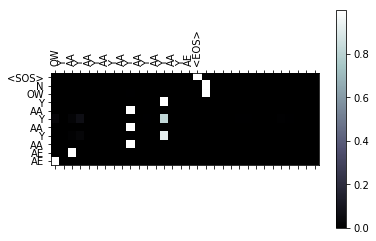

None
("come up in the spot lookin' extra fly", "'fore the day i die i'mma touch the sky")
8350
['AY', 'AY', 'AH', 'AH', 'DH', 'AH', 'T', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', '<SOS>']
input:
['', 'K', 'AH', 'M', 'AH', 'P', 'IH', 'N', 'DH', 'AH', 'S', 'P', 'AA', 'T', 'L', 'UH', 'K', 'IH', 'N', 'EH', 'K', 'S', 'T', 'R', 'AH', 'F', 'L', 'AY', '<EOS>']
output
['<SOS>', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', 'AH', 'T', 'AH', 'DH', 'AH', 'AH', 'AY', 'AY']


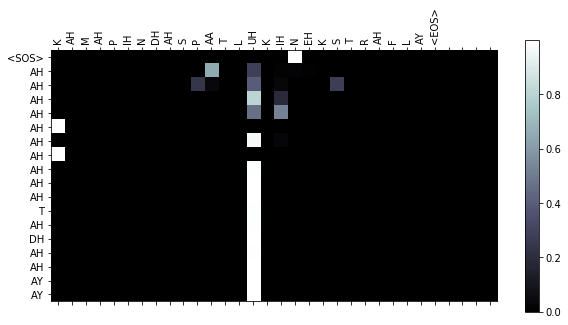

None
('for me', 'for me')
3271
['IY', 'M', 'ER', 'F', '<SOS>']
input:
['', 'F', 'ER', 'M', 'IY', '<EOS>']
output
['<SOS>', 'F', 'ER', 'M', 'IY']


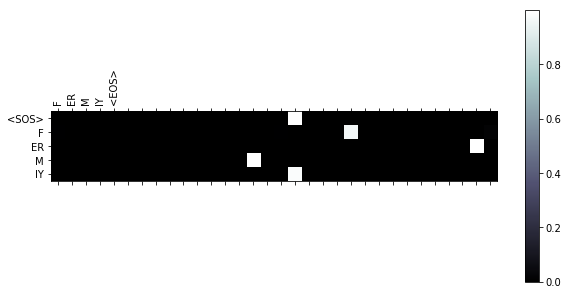

None
('surely hip hop is never a problem', 'in harlem only in boston')
3013
['M', 'AH', 'OW', 'D', 'IY', 'W', 'N', 'IH', 'T', 'N', 'T', 'AH', 'N', 'N', 'N', '<SOS>']
input:
['', 'SH', 'UH', 'R', 'L', 'IY', 'HH', 'IH', 'P', 'HH', 'AA', 'P', 'IH', 'Z', 'N', 'EH', 'V', 'ER', 'AH', 'P', 'R', 'AA', 'B', 'L', 'AH', 'M', '<EOS>']
output
['<SOS>', 'N', 'N', 'N', 'AH', 'T', 'N', 'T', 'IH', 'N', 'W', 'IY', 'D', 'OW', 'AH', 'M']


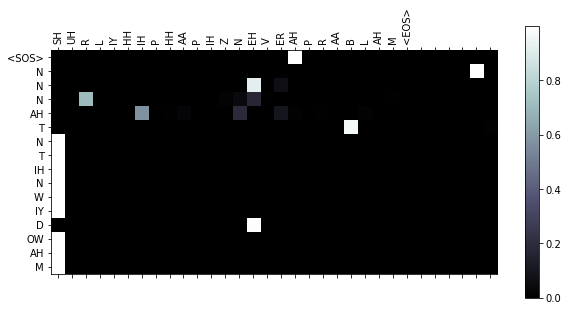

None
('look at my dab bitch dab', 'look at my dab bitch dab')
13575
['B', 'AE', 'D', 'CH', 'IH', 'B', 'B', 'AE', 'D', 'AY', 'M', 'AY', 'M', 'IH', 'IH', 'K', 'UH', 'L', '<SOS>']
input:
['', 'L', 'UH', 'K', 'AE', 'T', 'M', 'AY', 'D', 'AE', 'B', 'B', 'IH', 'CH', 'D', 'AE', 'B', '<EOS>']
output
['<SOS>', 'L', 'UH', 'K', 'IH', 'IH', 'M', 'AY', 'M', 'AY', 'D', 'AE', 'B', 'B', 'IH', 'CH', 'D', 'AE', 'B']


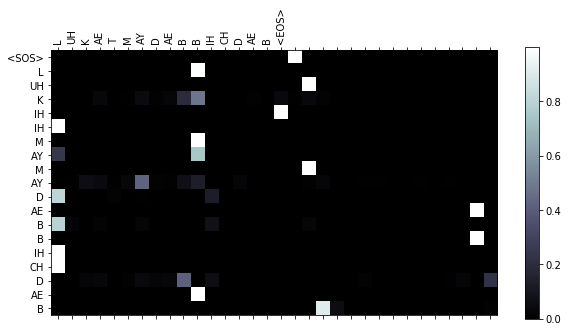

None
('hey yo swing swing swing to chop chop chop', "yo that's the sound when mc's get mopped")
371
['AA', 'AA', 'K', 'NG', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', '<SOS>']
input:
['', 'HH', 'EY', 'Y', 'OW', 'S', 'W', 'IH', 'NG', 'S', 'W', 'IH', 'NG', 'S', 'W', 'IH', 'NG', 'T', 'IH', 'CH', 'AA', 'P', 'CH', 'AA', 'P', 'CH', 'AA', 'P', '<EOS>']
output
['<SOS>', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'IH', 'NG', 'K', 'AA', 'AA']


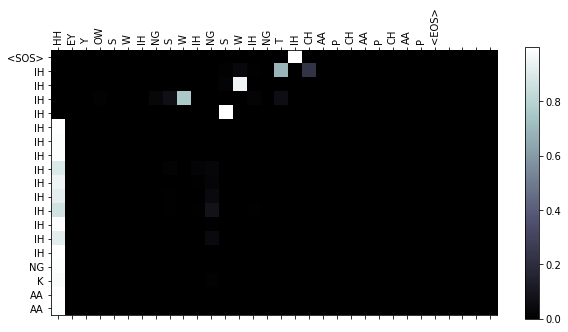

None


In [107]:
good_pairs = [2030,8350,3271,3013,13575,371]
for p in good_pairs:
    pair = normal_pairs[p]
    print(pair)
    print(normal_pairs.index(pair))

    l = []
    for w in clean_line(convert_to_phonemes(pair[0]), []):
        for s in w[0]:
            l.append(s)
    #print(l)

    out = evaluateAndShowAttention(l, encoder_256_tfr_50, decoder_256_tfr_50)
    print(out.reverse())

In [106]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.show()


def evaluateAndShowAttention(input_sentence, encoder, decoder):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    #print('input =', input_sentence)
    #print('output =', ' '.join(output_words))
    print(output_words)
    showAttention(input_sentence, output_words[::-1], attentions)
    return output_words

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [12]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        pair_as_text = normal_pairs[pairs.index(pair)]
        print('>', pair[0])
        print('>', pair_as_text[0])
        print('=', pair[1])
        print('=', pair_as_text[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [14]:
teacher_forcing_ratio = 0.1
def trainAttentionBackwards(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH+2):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

        
    decoder_input = Variable(torch.LongTensor([[EOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(1, target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(1, target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == SOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [15]:
def trainItersAttentionBackwards(encoder, decoder, n_iters, plot_losses, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        # create inverted indices
        idx = [i for i in range(target_variable.size(0)-1, -1, -1)]
        idx = Variable(torch.LongTensor(idx))
        inverted_tensor = target_variable.index_select(0, idx)
        #print(inverted_tensor)
        reversed_list = []
        for r in range(len(target_variable.data)):
            reversed_list.append(target_variable.data[(len(target_variable.data)-1)-r][0])
        
        target_variable = inverted_tensor

        loss = trainAttentionBackwards(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            torch.save(encoder.state_dict(), 'encoder_512_tfr_50_100000.pt')
            torch.save(decoder.state_dict(), 'decoder_512_tfr_50_100000.pt')
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [17]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH+2):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [18]:
hidden_size = 256
teacher_forcing_ratio = .5
encoder_256_tfr_50 = EncoderRNN(lyr.n_phonemes, hidden_size)
decoder_256_tfr_50 = AttnDecoderRNN(hidden_size, lyr.n_phonemes, dropout_p=0.1)



encoder_256_tfr_50.load_state_dict(torch.load('encoder_256_tfr_50.pt'))
decoder_256_tfr_50.load_state_dict(torch.load('decoder_256_tfr_50.pt'))

plot_losses = []

# To train, uncomment this. 
#trainItersAttentionBackwards(encoder_512_tfr_100_new_rhyme, decoder_512_tfr_100_new_rhyme, 75000, plot_losses, print_every=1000)

In [19]:
torch.save(encoder_256_tfr_50.state_dict(), "encoder_256_tfr_50.pt")
torch.save(decoder_256_tfr_50.state_dict(), "decoder_256_tfr_50.pt")

In [20]:
def beam_search(beam_size, encoder, decoder, line, first_input, first_hidden, encoder_outputs, old_beams=None, reverse=False):
    input_variable = variableFromLine(lyr, line)
    
    # Get initial decoder outputs. The input is the not up for debate, so it starts every beam as well.
    dec_out, dec_hidden, dec_attention = decoder(
        first_input, first_hidden, encoder_outputs)
    
    
    #This will start off all of our beams.
    dec_hidden_start = dec_hidden
    
    # take out the predictions, these are our beams
    proposed_v, proposed_i = dec_out.data.topk(beam_size)

    #convert the indices to list of lists w/ one item
    proposed_i = [x for x in proposed_i[0]]
    proposed_v = [x for x in proposed_v[0]]
    
    
    if(old_beams is not None):
        print('got old beams!')
        beams = old_beams
    else:
        print('using new beams.....')
        beams = []    
        for i in range(beam_size):
            beam = Beam(beam_size)

            beam.pho.append(proposed_i[i])
            beam.prob.append(proposed_v[i])
            beam.update_prob(reverse)

            beams.append(beam)
            
    #this for loop should go until all beams are EOS
    beams_finished = False
    count = 0
    while not beams_finished:
        count += 1
        extended_beams = []

        for j in range(len(beams)):
            extended_beams.append(beams[j].extend_beams(beam_size, encoder, decoder, dec_hidden_start, reverse))

        # we get the extended beams in lists of 5, so now extended beams is a matrix.
        # we flatten it to find the highest value easier.

        flat_list = []
        for sublist in extended_beams:
            for item in sublist:
                flat_list.append(item)
        flat_list = sorted(flat_list, key=lambda beam: beam.total_sum, reverse=True)
        
        

            
        beams = flat_list[:beam_size]
        
        for beam in beams:
            if reverse:
                prediction_end = SOS_token
            else: 
                prediction_end = EOS_token
                
            if beam.pho[-1] == prediction_end:
                beams_finished = True
            else:
                beams_finished = False
                
        print('On search %d:' % count)
        for b in flat_list[:beam_size]:
            print(b.pho, b.total_sum)
    return beams


    #       When expanding this beam, check if it's valid. 
    #       if valid is false and the final pho isn't EOS, 
    #            dont expand the beam. 
    #       if valid is false and the final pho is EOS, don't expand but keep
    
 


In [21]:
class Beam(object):
    
    def __init__(self, beam_width):
        self.prob = []
        self.pho = []
        self.total_sum = 0
        self.valid = True
        self.beam_width = beam_width

        
    def extend_beams(self, beam_width, encoder, decoder, first_hidden, reverse):
        if reverse:
            token = SOS_token
        else:
            token = EOS_token
            
        if self.pho[-1] == token or self.valid == False:
            print('reached the end of a beam, either it is invalid or the last phoneme is the signal to stop predictions')
            return[self]
            
        guess_hidden = first_hidden
        
        #first, run the phonemes of the beam thru the decoder, using teacher forcing the whole way
        for phoneme_index in self.pho:
            dec_input =  Variable(torch.LongTensor([[phoneme_index]]))
            #print(dec_input)
            print(guess_hidden.shape)
            print(encoder_outputs.shape)
            guess_out, guess_hidden, guess_attention = decoder(
                dec_input, guess_hidden, encoder_outputs)
            

        # second, take the top beam_size predictions of the final out and put them in new beams
        guess_v, guess_i = guess_out.topk(beam_size)

        guess_i = [x for x in guess_i[0]]
        guess_v = [x for x in guess_v[0]]

        extended_beams = []
        
        for i in range(beam_width):
            
            new_beam = Beam(beam_width)
            for n in self.pho:
                new_beam.pho.append(n)
                
            for p in self.prob:
                new_beam.prob.append(p)

            new_beam.pho.append(guess_i[i].data[0])
            new_beam.prob.append(guess_v[i].data[0]) 
            new_beam.update_prob(reverse)
            
            extended_beams.append(new_beam)

            
        
        #print('here are the extended_beams we just made:')
        #for i in range(len(extended_beams)):
        #    print(extended_beams[i].pho)
        
        #return the extended beams
        return extended_beams


    
    def update_prob(self, reverse=False):
        s = 0
        for p in self.prob:
             s += p     
        if len(self.pho) > 1:
            
            # [0, 1]
            # prev = 0
            # cur = 1
            for i in range(1, len(self.pho)):
                prev = self.pho[i-1]
                cur = self.pho[i]
                
            #try:
                if reverse:
                    # P(1|2)
                    # want prob cur appears given the pred of prev <-- works i think then
                    s += math.log(lyr.getCondProbReverse(cur, prev))
                else:
                    # P(2|1)
                    s += math.log(lyr.getCondProb(cur, prev))
#             except:
#                 print('something went wrong, probabily cond_prob is 0')
#                 print(cur, prev)
                
                
        self.total_sum = s/len(self.prob)
        

In [22]:
def evaluateRandomlyAttention(encoder, attn_decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        pair_as_text = normal_pairs[pairs.index(pair)]
        print('>', pair[0])
        print('>', pair_as_text[0])
        print('=', pair[1])
        print('=', pair_as_text[1])

        output_words, attentions = evaluateAttention(encoder, attn_decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [23]:
beam_size = 5
def evaluateAttentionBackwards(encoder, decoder, line, reverse=False, max_length=MAX_LENGTH+2):
    input_variable = variableFromLine(lyr, line)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    #print(encoder_hidden)
    
    for ei in range(input_length):
        #print(ei)
        encoder_output, encoder_hidden = encoder(input_variable[ei], 
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    token = EOS_token if reverse else SOS_token
    decoder_input = Variable(torch.LongTensor([[token]]))  # SOS or EOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = [] 
    decoder_attentions = torch.zeros(max_length, max_length)

    
    beams, beam_values = beam_search(beam_size, encoder, decoder, line,
                                     decoder_input, decoder_hidden, encoder_outputs, reverse=True)
    
    print(beams)
    print(beam_values)
    

    return beams, beam_values